## Trend Calculation [Argentina]


#### Importing the Relevant Libraries

In [2]:
import pandas as pd
import numpy as np
import os
from IPython.display import display
import matplotlib.pyplot as plt
import warnings
import openpyxl
from get_regression_coefs_general import get_regression_coefs # import our function to get GDP trend

#### Cleaning the Data 

In [3]:
# Import the Data from the xlsx file
filename = r"pwt100.xlsx"  

# Load the "Data" sheet and filter for Argentina
df = pd.read_excel(filename, sheet_name="Data", engine="openpyxl")
filtered_df = df[df.iloc[:, 1] == "Argentina"].copy()  # Make an explicit copy

# Index Match the Header
legend_df = pd.read_excel(filename, sheet_name="Legend", engine="openpyxl") # Read the legend sheet
mapping = dict(zip(legend_df.iloc[:, 0].str.strip(), legend_df.iloc[:, 1].str.strip()))  # Clean mapping keys
filtered_df = filtered_df.rename(columns=lambda col: mapping[col] if col in mapping else col)

# Clean to numeric and datetime format
filtered_df.iloc[:, 4:] = filtered_df.iloc[:, 4:].apply(pd.to_numeric, errors='coerce')  # Ensure numeric data
filtered_df['Year'] = pd.to_datetime(filtered_df['Year'], format='%Y', errors='coerce')
filtered_df.reset_index(drop=True)

,3-letter ISO country code,Country name,Currency unit,Year,Expenditure-side real GDP at chained PPPs (in mil. 2017US$),Output-side real GDP at chained PPPs (in mil. 2017US$),Population (in millions),Number of persons engaged (in millions),Average annual hours worked by persons engaged,"Human capital index, based on years of schooling and returns to education; see Human capital in PWT9.",...,Share of merchandise exports at current PPPs,Share of merchandise imports at current PPPs,Share of residual trade and GDP statistical discrepancy at current PPPs,"Price level of household consumption, price level of USA GDPo in 2017=1","Price level of capital formation, price level of USA GDPo in 2017=1","Price level of government consumption, price level of USA GDPo in 2017=1","Price level of exports, price level of USA GDPo in 2017=1","Price level of imports, price level of USA GDPo in 2017=1","Price level of the capital stock, price level of USA in 2017=1","Price level of the capital services, price level of USA=1"
0,ARG,Argentina,Argentine Peso,1950-01-01,5.030395e+04,5.010876e+04,17.091824,6.608833,2034.000000,1.816503,...,0.122540,-0.060423,-0.012842,0.193067,0.422730,0.273050,0.117665,0.107814,0.292420,NaN
1,ARG,Argentina,Argentine Peso,1951-01-01,5.267796e+04,5.133917e+04,17.457578,6.713252,2037.866753,1.830769,...,0.100497,-0.074776,-0.016469,0.213862,0.366893,0.277869,0.142259,0.118755,0.264830,NaN
2,ARG,Argentina,Argentine Peso,1952-01-01,4.767721e+04,4.685510e+04,17.815967,6.819321,2041.740856,1.845147,...,0.077847,-0.058380,-0.033148,0.229605,0.366508,0.296447,0.126297,0.130694,0.268225,NaN
3,ARG,Argentina,Argentine Peso,1953-01-01,4.952967e+04,4.991715e+04,18.168618,6.927065,2045.622325,1.859638,...,0.106709,-0.041785,-0.022161,0.230860,0.370191,0.315614,0.110863,0.102362,0.267306,NaN
4,ARG,Argentina,Argentine Peso,1954-01-01,5.183538e+04,5.225477e+04,18.517168,7.036511,2049.511172,1.874243,...,0.108594,-0.051525,-0.029199,0.229684,0.381629,0.327768,0.094007,0.093510,0.273750,8.502229
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,ARG,Argentina,Argentine Peso,2015-01-01,9.148502e+05,9.131035e+05,43.075416,19.854450,1703.468539,2.975289,...,0.099057,-0.107307,-0.005448,0.814612,0.825699,0.446212,0.633933,0.620426,0.541800,1.215443
66,ARG,Argentina,Argentine Peso,2016-01-01,9.113680e+05,9.087713e+05,43.508460,19.723175,1646.512532,3.005213,...,0.102169,-0.100915,-0.013928,0.704616,0.736538,0.377989,0.627567,0.613758,0.467809,1.056981
67,ARG,Argentina,Argentine Peso,2017-01-01,1.026128e+06,1.022513e+06,43.937140,20.033661,1648.812832,3.035439,...,0.089602,-0.106394,0.011239,0.640839,0.770372,0.498410,0.637246,0.614945,0.512517,1.143677
68,ARG,Argentina,Argentine Peso,2018-01-01,1.025861e+06,1.021129e+06,44.361150,20.135071,1638.440039,3.065968,...,0.090679,-0.101482,0.036473,0.521541,0.660731,0.376825,0.664090,0.630823,0.412905,0.875886


## Trend calculation. Calculate a trend time paths for (the natural logs of) (i) realGDP and (ii) real GDP per capita. 

All at constant 2017 national prices using data over the whole sample. We will provide a simple template Python program that you can use to fit a time trend. Present two panels with the natural logarithm of each variable and the corresponding trend time path.

- As a robustness exercise, use the levels instead of log levels in the trend regression.

### Trend Time Paths

Disclaimer: We fit the trend paths based on a 20 year rolling window. The reason for this is because we believe these time paths are sufficiently long to not capture short term fluctuations but sufficiently short to see long term structural shifts in the economy
 - Additive Linear Model
 - Additive Quadratic Model
 - Exponential Linear Model
 - Exponential Quadratic

##### (i) Real GDP 

##### 1) Additive Linear Model

In [62]:
# Compute separate sample sizes for the subsample used for estimation and the whole sample

years = filtered_df["Year"].dt.year.values # Ensure the years array matches the length of Y
Yhat_add_linear = np.empty(len(years))  # Initialise an empty vector for the estimated GDP trend
ymax = filtered_df["Year"].dt.year.values[-1]  # Maximum year in the data
ymin = filtered_df["Year"].dt.year.values[0]  # Minimum year in the data
Y = filtered_df["Expenditure-side real GDP at chained PPPs (in mil. 2017US$)"].values

# Split years into 10-year periods
for start_year in range(ymin, ymax + 1, 20):
    # Determine the range for this 10-year period
    end_year = min(start_year + 19, ymax)
    period_mask = (years >= start_year) & (years <= end_year)  # Mask for years in the current block
    
    # Extract Y and define regressors for the period (may be less than 10 years for the last block)
    Y_period = Y[period_mask]
    x1 = np.ones(len(Y_period))  # Intercept term
    x2 = np.arange(1, len(Y_period) + 1)  # Time trend term

    # Perform regression only if there are years in the block
    if len(Y_period) > 0:
        a_add_lin, b_add_lin = get_regression_coefs(Y_period, x1, x2)

        # Predict Yhat for this period
        for idx, t in enumerate(np.where(period_mask)[0]):
            Yhat_add_linear[t] = a_add_lin + b_add_lin * (idx + 1)  # Compute predictions


##### 2) Additive Quadratic Model

In [63]:
Yhat_add_quad = np.empty(len(years))  # Initialise an empty vector for the estimated GDP trend
for start_year in range(ymin, ymax + 1, 20):
    # Determine the range for this 10-year period
    end_year = min(start_year + 19, ymax)
    period_mask = (years >= start_year) & (years <= end_year)  # Mask for years in the current block
    
    # Extract Y and define regressors for the period (may be less than 10 years for the last block)
    Y_period = Y[period_mask]
    x1 = np.ones(len(Y_period))  # Intercept term
    x2 = np.arange(1, len(Y_period) + 1)  # Time trend term
    x3 = x2 ** 2  # Quadratic term

    # Perform regression only if there are years in the block
    if len(Y_period) > 0:
        a_add_quad, b_add_quad, c_add_quad = get_regression_coefs(Y_period, x1, x2,x3)

        # Predict Yhat for this period
        for idx, t in enumerate(np.where(period_mask)[0]):
            Yhat_add_quad[t] = a_add_quad + b_add_quad * (idx + 1) + c_add_quad * (idx + 1)**2  # Compute predictions


##### Plotting Additive Models

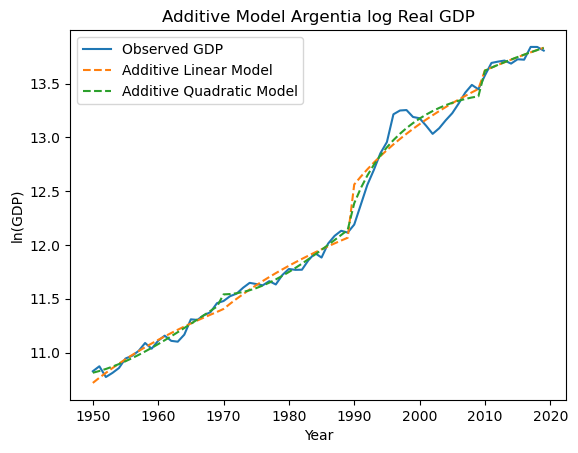

In [64]:
# Plot the results
plt.figure()
plt.plot(filtered_df["Year"], np.log(filtered_df["Expenditure-side real GDP at chained PPPs (in mil. 2017US$)"]), label="Observed GDP")
plt.plot(filtered_df["Year"], np.log(Yhat_add_linear), label="Additive Linear Model", linestyle="--")
plt.plot(filtered_df["Year"], np.log(Yhat_add_quad), label="Additive Quadratic Model", linestyle="--")

# Add labels and title
plt.xlabel("Year")
plt.ylabel("ln(GDP)")
plt.title("Additive Model Argentina log Real GDP")
plt.legend()
plt.show()

##### 3) Exponential Linear Model

In [125]:
Yhat_exp_linear = np.empty(len(years))  # Initialise an empty vector for the estimated GDP trend
for start_year in range(ymin, ymax + 1, 20):
    # Determine the range for this 20-year period
    end_year = min(start_year + 19, ymax)
    period_mask = (years >= start_year) & (years <= end_year)  # Mask for years in the current block
    
    # Extract Y and define regressors for the period
    Y_period = Y[period_mask]
    x1 = np.ones(len(Y_period))  # Intercept term
    x2 = np.exp(np.arange(1, len(Y_period) + 1))  

    # Perform regression only if there are years in the block
    if len(Y_period) > 0:
        # Transform Y for exponential growth
        log_Y_period = np.log(Y_period)  # Take logarithm to linearize exponential trend -- Key difference!!
        a_exp_lin, b_exp_lin = get_regression_coefs(log_Y_period, x1, x2)

        # Predict Yhat for this period
        for idx, t in enumerate(np.where(period_mask)[0]):
            Yhat_exp_linear[t] = a_exp_lin + b_exp_lin * np.exp(idx + 1)  # Exponentiate to get back to original scale

##### 4) Exponential Quadratic Model

In [126]:
Yhat_exp_quad = np.empty(len(years))  # Initialise an empty vector for the estimated GDP trend
for start_year in range(ymin, ymax + 1, 20):
    # Determine the range for this 20-year period
    end_year = min(start_year + 19, ymax)
    period_mask = (years >= start_year) & (years <= end_year)  # Mask for years in the current block
    
    # Extract Y and define regressors for the period
    Y_period = Y[period_mask]
    x1 = np.ones(len(Y_period))  # Intercept term
    t = np.arange(1, len(Y_period) + 1)  # Time indices for the block
    x2 = t  # Linear time trend
    x3 = t ** 2  # Quadratic time trend
    # Perform regression only if there are years in the block
    
    if len(Y_period) > 0:
        # Fit the regression model
        a_exp_quad, b_exp_quad, c_exp_quad = get_regression_coefs(Y_period, x1, x2, x3)

        # Predict Yhat for this period using exponential transformations during prediction
        for idx, t in enumerate(np.where(period_mask)[0]):
            Yhat_exp_quad[t] = (
                a_exp_quad
                + b_exp_quad * np.exp(idx + 1)  # Exponential of linear trend
                + c_exp_quad * np.exp((idx + 1) ** 2)  # Exponential of quadratic trend
            )

##### Plotting Exponential Models

- Note that there is a very large outlier in the exponential quadratic model! Hence it is currently excluded. Up for discussion what to do

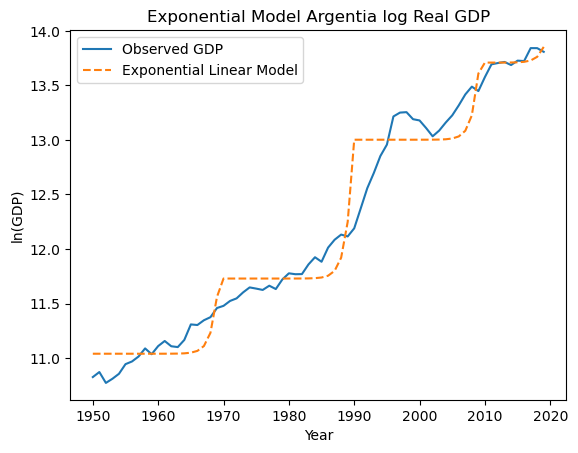

In [134]:
# Plot the results
plt.figure()
plt.plot(filtered_df["Year"], np.log(filtered_df["Expenditure-side real GDP at chained PPPs (in mil. 2017US$)"]), label="Observed GDP")
plt.plot(filtered_df["Year"], Yhat_exp_linear, label="Exponential Linear Model", linestyle="--")
 # plt.plot(filtered_df["Year"], Yhat_exp_quad, label="Exponential Quadratic Model", linestyle="--")
# Add labels and title
plt.xlabel("Year")
plt.ylabel("ln(GDP)")
plt.title("Exponential Model Argentia log Real GDP")
plt.legend()
plt.show()

### BELOW IS A DIFFERENT WAY OF TACKLING PART A

Text(0.5, 1.0, 'Additive Quadratic: GDP & trend')

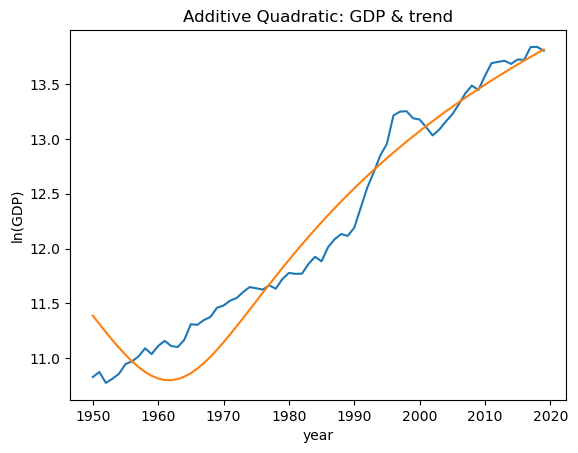

In [24]:
# Initialise predicted values yhat
T_all = data["year"].max() - (ymin - 1) # number of all years in the data after ymin
Yhat_add_quad = np.empty(T_all)

# Create loop to compute trend for all years
for t in range(T_all):
    Yhat_add_quad[t] = a_add_quad + b_add_quad * (t + 1) + c_add_quad * (t+1) ** 2 # recall that Python indexing starts at 0

# Let us convert into log-units
yhat_add_quad= np.log(Yhat_add_quad)

plt.figure()
#one could add options such as a particular size and use instead
#plt.figure(figsize=(7, 5))
plt.plot(filtered_df['Year'],np.log(filtered_df['Expenditure-side real GDP at chained PPPs (in mil. 2017US$)']))
plt.plot(filtered_df['Year'],yhat_add_quad) # Value already logged

#labels
plt.xlabel("year")
plt.ylabel("ln(GDP)")

#title
plt.title("Additive Quadratic: GDP & trend")




##### (i) Real GDP - 3) Exponential Linear Model

In [25]:
# 3.3) Exponential Linear Model

x1 = np.empty(T) # initialise an empty vector for the first regressor
x2 = np.empty(T) # initialise an empty vector for the second regressor

for t in range(T):
    x1[t] = 1.
    x2[t] = np.exp(t + 1) # recall that Python starts indexing at 0

a_exp_linear, b_exp_linear = get_regression_coefs(Y, x1, x2)

Text(0.5, 1.0, 'Exponential Linear: GDP & trend')

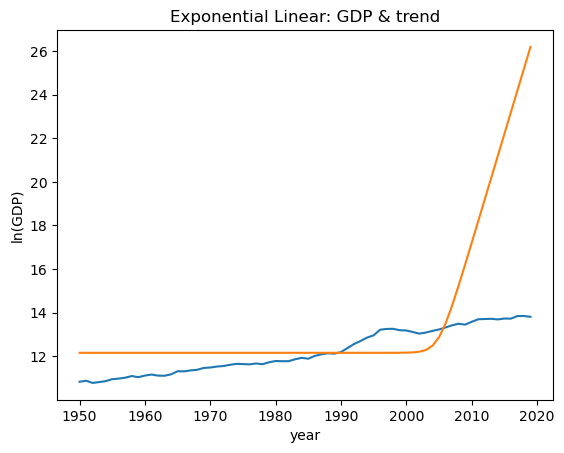

In [26]:
# Initialise predicted values yhat
Yhat_exp_linear = np.empty(T_all)

# Create loop to compute trend for all years
for t in range(T_all):
    Yhat_exp_linear[t] = a_exp_linear + b_exp_linear * np.exp(t+1)  # recall that Python indexing starts at 0

# Let us convert into log-units
Yhat_exp_linear= np.log(Yhat_exp_linear)

plt.figure()
#one could add options such as a particular size and use instead
#plt.figure(figsize=(7, 5))
plt.plot(filtered_df['Year'],np.log(filtered_df['Expenditure-side real GDP at chained PPPs (in mil. 2017US$)']))
plt.plot(filtered_df['Year'],Yhat_exp_linear) # Value already logged

#labels
plt.xlabel("year")
plt.ylabel("ln(GDP)")

#title
plt.title("Exponential Linear: GDP & trend")

##### (i) Real GDP - 4) Exponential Quadratic Model

In [30]:
# 3.3) Exponential Quadratic Model

x1 = np.empty(T) # initialise an empty vector for the first regressor
x2 = np.empty(T) # initialise an empty vector for the second regressor
scaling_factor = 1000
for t in range(T):
    x1[t] = 1.
    x2[t] = np.exp(t + 1) # recall that Python starts indexing at 0
    x3[t] = np.exp((t + 1) ** 2 / scaling_factor)

a_exp_quad, b_exp_quad, c_exp_quad = get_regression_coefs(Y, x1, x2,x3)

Text(0.5, 1.0, 'Exponential Linear: GDP & trend')

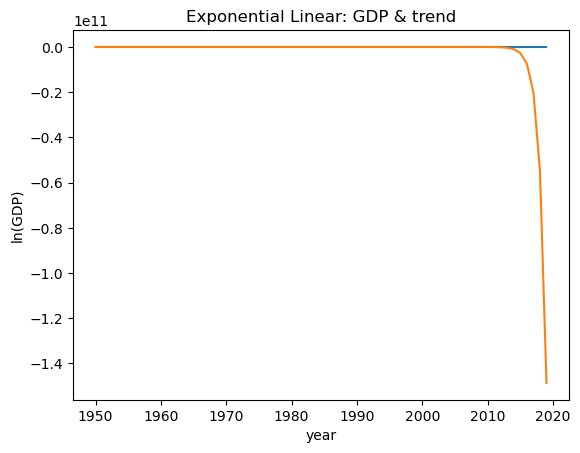

In [32]:
# Initialise predicted values yhat
Yhat_exp_quad = np.empty(T_all)

# Create loop to compute trend for all years
for t in range(T_all):
    Yhat_exp_quad[t] = a_exp_quad + b_exp_quad * np.exp(t+1) + c_exp_quad * np.exp((t+1)**2/scaling_factor)  # recall that Python indexing starts at 0

# Let us convert into log-units
Yhat_exp_linear= np.log(Yhat_exp_linear)

plt.figure()
#one could add options such as a particular size and use instead
#plt.figure(figsize=(7, 5))
plt.plot(filtered_df['Year'],np.log(filtered_df['Expenditure-side real GDP at chained PPPs (in mil. 2017US$)']))
plt.plot(filtered_df['Year'],Yhat_exp_quad) # Value already logged

#labels
plt.xlabel("year")
plt.ylabel("ln(GDP)")

#title
plt.title("Exponential Linear: GDP & trend")

##### (ii) Real GDP per Capita

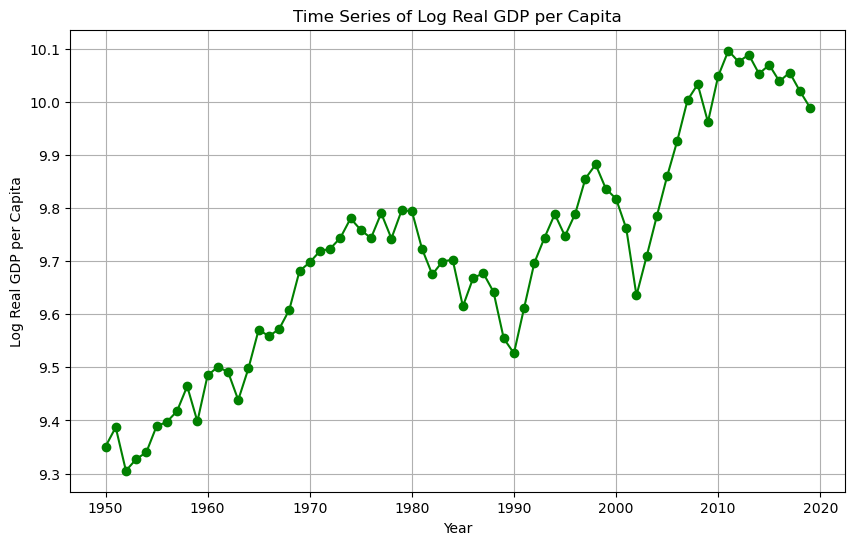

In [8]:
# Columns for Real GDP and Population
gdp_column = "Real GDP at constant 2017 national prices (in mil. 2017US$)"
population_column = "Population (in millions)"
gdp_per_capita_column = "Log Real GDP per capita"

# Calculate Real GDP per capita and take the bnatural log
if all(col in filtered_df.columns for col in [gdp_column, population_column]):
    filtered_df[gdp_per_capita_column] = [
        np.log(gdp / pop) if pd.notnull(gdp) and pd.notnull(pop) and pop > 0 else np.nan
        for gdp, pop in zip(filtered_df[gdp_column], filtered_df[population_column])
    ]
else:
    raise KeyError(f"Columns '{gdp_column}' or '{population_column}' not found in DataFrame.")

# Plot the time series graph
plt.figure(figsize=(10, 6))
plt.plot(filtered_df['Year'], filtered_df[gdp_per_capita_column], color='green', linestyle='-', marker='o')
plt.xlabel('Year')
plt.ylabel('Log Real GDP per Capita')
plt.title('Time Series of Log Real GDP per Capita')
plt.grid(True)
plt.show()


## Description Part of the Project

### 2. Solow Model - Is the Solow model capable of explaining part of the growth developments in your allocated country?

### 4. Romer model - Is the Romer model useful to explain part of the growth patterns in your country? This does not have to be the Romer model with constant parameters. Also, it is perfectly fine to be critical of the Romer model if your country does not provide support.